## Whole body segmentation using `monai`

* MONAI stands for "Medical Open Network for Artificial Intelligence" and is essentially an extension of PyTorch for machine learning with medical data, containing many important functions. If you're doing AI research in medicine, you **must** use MONAI.
* https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid40.ipynb
* https://medium.com/@davesimms44/using-monai-bundle-and-the-monai-model-zoo-to-segment-medical-imaging-data-7ade49699248

In [45]:
import os
import numpy as np
import torch 
import matplotlib.pyplot as plt
from tcia_utils import nbia
from monai.bundle import ConfigParser, download
from monai.transforms import LoadImage, LoadImaged, Orientation, Orientationd, EnsureChannelFirst, EnsureChannelFirstd, Compose
from rt_utils import RTStructBuilder
from scipy.ndimage import label, measurements
import json
import nibabel

In [46]:
# Check CUDA and Torch installations
print(torch.cuda.is_available())  # Returns True if CUDA is available
print(torch.__version__)  # Displays the PyTorch version
print(torch.cuda.get_device_name(0)) # Display GPU device name

True
1.13.0+cu116
NVIDIA GeForce RTX 3080 Laptop GPU


In [47]:
datadir = ".\\data"
modeldir = ".\\model" 

### Download data

* Data was obtained from The Cancer Imaging Archive (TCIA)

In [48]:
cart_name = "nbia-56561691129779503"
cart_data = nbia.getSharedCart(cart_name)
nbia.downloadSeries(cart_data, format="df", path=datadir)

2025-04-01 19:12:52,825:INFO:Success - Token saved to global api_call_headers variable and expires at 2025-04-01 21:12:52.825714
2025-04-01 19:12:52,825:INFO:Accessing public data anonymously. To access restricted data use nbia.getToken() with your credentials.
2025-04-01 19:12:52,825:INFO:Calling getContentsByName with parameters {'name': 'nbia-56561691129779503'}
2025-04-01 19:12:53,690:INFO:Downloading 1 out of 1 Series Instance UIDs (scans).
2025-04-01 19:12:53,690:INFO:Directory '.\data' already exists.
2025-04-01 19:12:53,690:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668 already downloaded and unzipped.
2025-04-01 19:12:54,501:INFO:Downloaded 0 out of 1 Series Instance UIDs (scans).
0 failed to download.
1 previously downloaded.


,Series UID,Collection,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Modality,SOP Class UID,...,License URL,Annotation Size,Date Released,Series Date,Protocol Name,Body Part Examined,Annotations Flag,Manufacturer Model Name,Software Versions,TimeStamp
0,1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195...,CPTAC-SAR,https://doi.org/10.7937/TCIA.2019.9bt23r95,C3N-00875,1.3.6.1.4.1.14519.5.2.1.3320.3273.530366014057...,PETWHOLEBODYLONGLD90 Adult,11-12-1999,CT WB 3.0 B30f,CT,1.2.840.10008.5.1.4.1.1.2,...,http://creativecommons.org/licenses/by/3.0/,0,Wed Mar 18 14:17:43 UTC 2020,Fri Nov 12 00:00:00 UTC 1999,WHOLEBODY_LONG_LD90,WHOLEBODY,false,Biograph20,VG51C,Wed Mar 18 14:17:43 UTC 2020


### Download model

* Segmentation model is obtained from https://monai.io/model-zoo.html

In [49]:
model_name = "wholeBody_ct_segmentation"
download(name=model_name, bundle_dir=modeldir)

2025-04-01 19:12:57,000 - INFO - --- input summary of monai.bundle.scripts.download ---
2025-04-01 19:12:57,001 - INFO - > name: 'wholeBody_ct_segmentation'
2025-04-01 19:12:57,001 - INFO - > bundle_dir: '.\\model'
2025-04-01 19:12:57,001 - INFO - > source: 'monaihosting'
2025-04-01 19:12:57,002 - INFO - > remove_prefix: 'monai_'
2025-04-01 19:12:57,002 - INFO - > progress: True
2025-04-01 19:12:57,002 - INFO - ---


2025-04-01 19:12:57,599 - INFO - Expected md5 is None, skip md5 check for file model\wholeBody_ct_segmentation_v0.2.5.zip.
2025-04-01 19:12:57,599 - INFO - File exists: model\wholeBody_ct_segmentation_v0.2.5.zip, skipped downloading.
2025-04-01 19:12:57,599 - INFO - Writing into directory: model.


### Load and  explore data

* The loaded CT image is a 3D volume with dimensions:
<br/>&nbsp;&nbsp;512 pixels in the width (x dimension),
<br/>&nbsp;&nbsp;512 pixels in the height (y dimension),
<br/>&nbsp;&nbsp;975 slices in the depth (z dimension).
* CT image contains both the pixel data (for all slices) and the image metadata

In [51]:
CT_folder = os.path.join(datadir, '1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668')
image_loader = LoadImage(image_only=True)
CT = image_loader(CT_folder)  
# Re-run cell [File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading..] 

In [52]:
CT.shape

torch.Size([512, 512, 975])

In [53]:
CT.meta

{'00200037': {'vr': 'DS', 'Value': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '00200032': {'vr': 'DS', 'Value': [-249.51171875, -401.01171875, 1937.0]},
 '00280030': {'vr': 'DS', 'Value': [0.9765625, 0.9765625, 2.0]},
 'spacing': array([0.9765625, 0.9765625, 2.       ]),
 'lastImagePositionPatient': array([-249.51171875, -401.01171875,  -11.        ]),
 spatial_shape: (512, 512, 975),
 space: RAS,
 original_affine: array([[-9.76562500e-01,  0.00000000e+00,  0.00000000e+00,
          2.49511719e+02],
        [ 0.00000000e+00, -9.76562500e-01,  0.00000000e+00,
          4.01011719e+02],
        [ 0.00000000e+00,  0.00000000e+00, -2.00000000e+00,
          1.93700000e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 affine: tensor([[-9.7656e-01,  0.0000e+00,  0.0000e+00,  2.4951e+02],
         [ 0.0000e+00, -9.7656e-01,  0.0000e+00,  4.0101e+02],
         [ 0.0000e+00,  0.0000e+00, -2.0000e+00,  1.9370e+03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e

### Plot all planes of the CT image

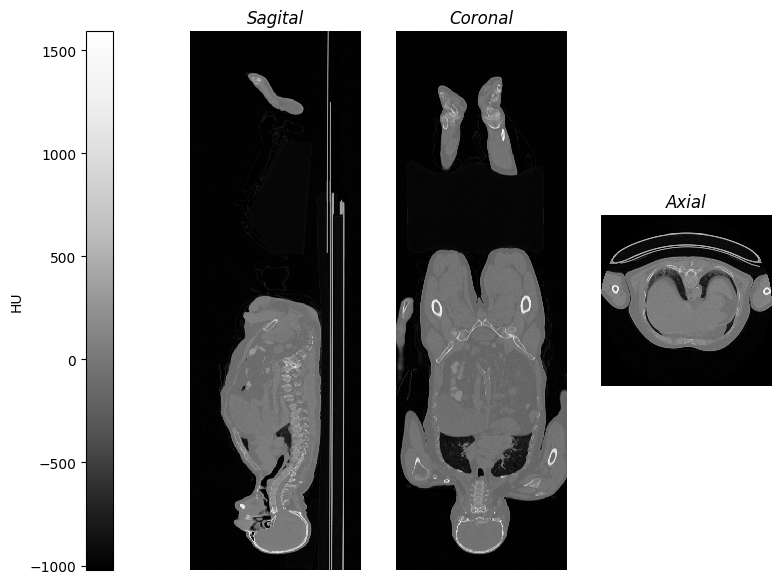

In [54]:
CT_sagital_slice = CT[250,:,:].cpu().numpy() 
CT_coronal_slice = CT[:,250,:].cpu().numpy() 
CT_axial_slice = CT[:,:,250].cpu().numpy() 
# Create subplots
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10,7)) 
# CT sagital slice
ax0.set_title("Sagital", fontstyle='italic')
pcmax0 = ax0.pcolormesh(CT_sagital_slice.T, cmap='Greys_r')
ax0.axis('off') # remove ticks
# CT coronal slice
ax1.set_title("Coronal", fontstyle='italic')
pcmax1 = ax1.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
ax1.axis('off')
# CT axial slice
ax2.set_title("Axial", fontstyle='italic')
pcmax2 = ax2.pcolormesh(CT_axial_slice.T, cmap='Greys_r')
ax2.axis('off') 
ax2.set_aspect('equal') # retain the original aspect ratio and do not stretched to one size
# Add the colorbar on the left 
fig.colorbar(pcmax0, ax=[ax0, ax1, ax2], location='left', label='HU')
# Show the plot
plt.show()

### Use MONAI to modify the CT image and reverse the body's position  
* Notice that the guy is upside-down!
* For additional info: https://docs.monai.io/en/stable/transforms.html

In [55]:
# Currently CT.shape returns torch.Size([512, 512, 975]) 
# Adjust or add the channel dimension of input data to ensure channel_first shape 
channel_transform = EnsureChannelFirst()
CT = channel_transform(CT)
# Now CT.shape returns torch.Size([1, 512, 512, 975]) 

# Change the input image’s orientation into the specified based on axcodes.
orientation_transform = Orientation(axcodes=('LPS')) # axcodes represents 3D orientation: (Left, Right), (Posterior, Anterior), (Inferior, Superior)
CT = orientation_transform(CT)

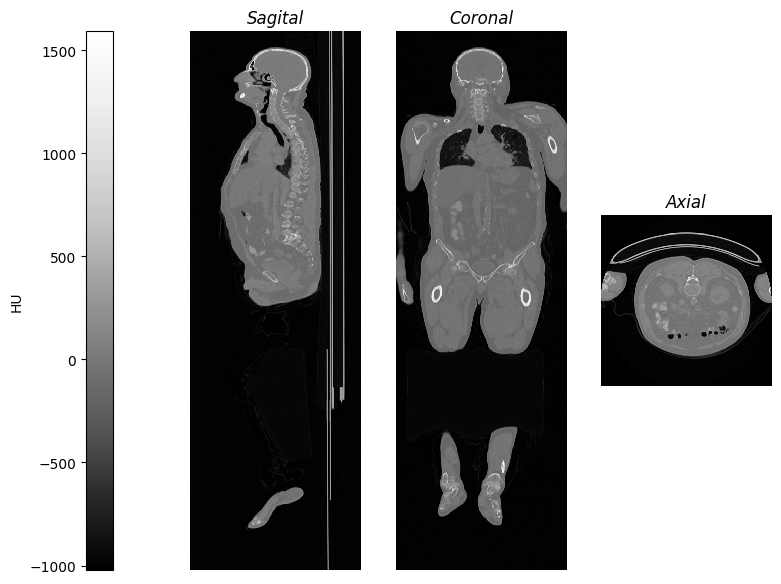

In [56]:
CT_sagital_slice = CT[0,250,:,:].cpu().numpy() 
CT_coronal_slice = CT[0,:,250,:].cpu().numpy() 
CT_axial_slice = CT[0,:,:,650].cpu().numpy() 
# Create subplots
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10,7)) 
# CT sagital slice
ax0.set_title("Sagital", fontstyle='italic')
pcmax0 = ax0.pcolormesh(CT_sagital_slice.T, cmap='Greys_r')
ax0.axis('off') # remove ticks
# CT coronal slice
ax1.set_title("Coronal", fontstyle='italic')
pcmax1 = ax1.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
ax1.axis('off')
# CT axial slice
ax2.set_title("Axial", fontstyle='italic')
pcmax2 = ax2.pcolormesh(CT_axial_slice.T, cmap='Greys_r')
ax2.axis('off') 
ax2.set_aspect('equal') # retain the original aspect ratio and do not stretched to one size
# Add the colorbar on the left 
fig.colorbar(pcmax0, ax=[ax0, ax1, ax2], location='left', label='HU')
# Show the plot
plt.show()

### Model initialization

* Create a config instance to read from the 'inference.json' file
* Obtain the model using the 'network' key from the json file (model will be initialized with random parameters)
* Configure model with the parameters given by the model.pt file
* Since the model won't be trained, but only use it for evaluation - use the eval() function

In [57]:
config_path = os.path.join(modeldir, 'wholeBody_ct_segmentation', 'configs', 'inference.json')
config = ConfigParser()
config.read_config(config_path)  

In [58]:
model_path = os.path.join(modeldir, 'wholeBody_ct_segmentation', 'models', 'model_lowres.pt')
model = config.get_parsed_content("network")
model.load_state_dict(torch.load(model_path))
model.eval()

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 64, eps=1e-05, a

### Preprocessing Pipeline

* Extract the preprocessing pipeline specified by the `inference.json` file
* It contains all the operations applied to the data before feeding it to the model

In [59]:
preprocessing = config.get_parsed_content("preprocessing") 
data = preprocessing({'image': CT_folder})

### Inferer  # TODO

* The `"inferer"` pipeline takes in the data and the model, and returns model output.
* It contains some extra processing steps (in this case it breaks the data into 96x96x96 chunks before feeding it into the model)

In [67]:
# TODO

inferer = config.get_parsed_content("inferer")
inferer.sw_batch_size = 1  # Reduce the batch size for sliding window inference

# Adds a new dimension at the beginning of the tensor to match the input shape expected by a model.
metatensor = data['image'].unsqueeze(0)  # metatensor.shape = torch.Size([1, 1, 334, 334, 1300])
# metatensor = metatensor.cuda() 

# Compute organ mask prediction, add it to dictionary
with torch.no_grad():
    # Feed data into model
    data['pred'] = inferer(metatensor, network=model)   
    # ERROR: NotImplementedError: Could not run 'aten::slow_conv3d_forward' with arguments from the 'CUDA' backend. 
    # 'aten::slow_conv3d_forward' is only available for these backends: [CPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, 
    # Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, 
    # AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMeta, AutogradPrivateUse1, 
    # AutogradPrivateUse2, AutogradPrivateUse3, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, 
    # Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PythonDispatcher].

OutOfMemoryError: CUDA out of memory. Tried to allocate 56.73 GiB (GPU 0; 16.00 GiB total capacity; 2.88 GiB already allocated; 10.49 GiB free; 3.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Postprocessing  # TODO  

* Postprocessing on data once the model has finished running 
* Postprocessing pipeline automatically saves the data to disk (can be changed manually in the json file)

In [ ]:
# TODO

postprocessing = config.get_parsed_content("postprocessing")

# Remove batch dimension in image and prediction
data['pred'] = data['pred'][0]
data['image'] = data['image'][0]

# Apply postprocessing to data
data = postprocessing(data)
segmentation = torch.flip(data['pred'][0], dims=[2])
segmentation = segmentation.cpu().numpy()

### Visualize results  # TODO  

In [ ]:
# TODO

slice_idx = 250
CT_coronal_slice = CT[0,:,slice_idx].cpu().numpy()
segmentation_coronal_slice = segmentation[:,slice_idx]

plt.subplots(1,2,figsize=(6,8))
plt.subplot(121)
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.axis('off')
plt.subplot(122)
plt.pcolormesh(segmentation_coronal_slice.T, cmap='nipy_spectral')
plt.axis('off')
plt.show()

The mask can be used for many purposes
* Radiotherapy planning to avoid certain organs
* (My research) utilization in SPECT/PET reconstruction algorithms to improve quantitation
* Compute organ volumes

**Example**: Computing bladder volume

In [ ]:
# TODO

number_bladder_voxels = (segmentation==13).sum().item()
voxel_volume_cm3 = np.prod(CT.meta['spacing']/10)
bladder_volume = number_bladder_voxels * voxel_volume_cm3
print(f'Bladder Volume {bladder_volume:.1f}cm^3') 